In [2]:
generating_class = 'VEHICLESCARRIER'
real_dir = 'DATASET54000'
fake_dir = 'DCGAN-F64'
fake_dirx4 = 'DCGAN-F64x4'

In [3]:
from keras import layers
from keras import ops
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os
import keras
import tensorflow as tf

import torch
import torchvision
import cv2

from realesrgan import RealESRGANer
from basicsr.archs.rrdbnet_arch import RRDBNet
from PIL import Image
import numpy as np
import requests

from skimage.metrics import structural_similarity as ssim
from torchvision import transforms
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from itertools import product


print(f"Versão do Tensorflow: {tf.__version__}")
devices = tf.config.list_physical_devices('GPU')
if devices:
    print(f"GPU disponivel: {devices}")
    print(f"Número de GPUs: {len(devices)}")
else:
    print("GPU não está disponível. Usando CPU")

print(f"PyTorch version: {torch.__version__}")
print(torchvision.__version__)
print(torch.cuda.is_available())  # Deve retornar True se a GPU estiver configurada corretamente
print(torch.cuda.get_device_name(0))  # Nome da GPU

2025-04-17 03:07:38.766755: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 03:07:39.014850: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.war

Versão do Tensorflow: 2.16.1
GPU disponivel: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Número de GPUs: 1
PyTorch version: 2.0.1+cu118
0.15.2+cu118
True
NVIDIA GeForce RTX 4090


2025-04-17 03:07:41.800477: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-17 03:07:41.800496: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Found 5400 files.


2025-04-17 03:07:52.991239: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-17 03:07:52.991275: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-17 03:07:52.991284: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-17 03:07:53.148291: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-17 03:07:53.148316: I external/local_xla/xla/stream_executor

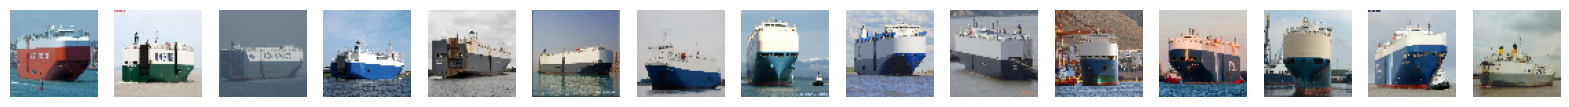

In [4]:
input_dir = str(real_dir + '/' + generating_class)

dataset = keras.utils.image_dataset_from_directory(
    input_dir, label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

for x in dataset:
    plt.figure(figsize=(20,15))

    for i in range (15):
        plt.subplot(1, 15, i + 1)
        plt.axis("off")
        plt.imshow((x.numpy() * 255).astype("int32")[i])
    break

In [5]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 512)    │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, d_steps):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = d_steps
        self.seed_generator = keras.random.SeedGenerator(1337)
        

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        total_d_loss = 0.0

        for _ in range(self.d_steps):
            random_latent_vectors = keras.random.normal(
                shape=(batch_size, self.latent_dim), seed=self.seed_generator
            )
    
            # Decode them to fake images
            generated_images = self.generator(random_latent_vectors)
    
            # Combine them with real images
            combined_images = ops.concatenate([generated_images, real_images], axis=0)
    
            # Assemble labels discriminating real from fake images
            labels = ops.concatenate(
                [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
            )
            # Add random noise to the labels - important trick!
            labels += 0.05 * tf.random.uniform(tf.shape(labels))
    
            # Train the discriminator
            with tf.GradientTape() as tape:
                predictions = self.discriminator(combined_images)
                d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
            total_d_loss += d_loss

        avg_d_loss = total_d_loss/self.d_steps
        
        # Update metrics
        self.d_loss_metric.update_state(avg_d_loss)

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))
        
        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.g_loss_metric.update_state(g_loss)
            
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [8]:
# Diretório onde os modelos serão salvos
checkpoint_dir = str("DCGAN-MODELS/" + generating_class)
os.makedirs(checkpoint_dir, exist_ok=True)

# Caminho do modelo salvo
checkpoint_path = os.path.join(checkpoint_dir, "dcgan_checkpoint.keras")
best_path = os.path.join(checkpoint_dir, "best_dcgan_checkpoint.keras")

# Verifica se há um modelo salvo para continuar o treinamento
if os.path.exists(checkpoint_path):
    print("Carregando modelo salvo para continuar o treinamento...")
    generator = keras.models.load_model(checkpoint_path)
    discriminator = keras.models.load_model(checkpoint_path.replace("dcgan_checkpoint", "dcgan_discriminator"))
else:
    print("Nenhum modelo salvo encontrado. Treinando do zero...")

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=15, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)
        self.best_fid = 999

    def on_epoch_end(self, epoch, logs=None):      
        calc_dir = str('DCGAN-RESULTS' + "/" + generating_class)
        os.makedirs(calc_dir, exist_ok=True)
        calc_filename = str(generating_class + "%d.png")
        calc_path = os.path.join(calc_dir, calc_filename)

        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = gan.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(calc_path % (i))

        real_class_dir = os.path.join(real_dir, generating_class)
        generated_class_dir = os.path.join('DCGAN-RESULTS', generating_class)
        
        real_files = [os.path.join(real_class_dir, f) for f in os.listdir(real_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
        gen_files = [os.path.join(generated_class_dir, f) for f in os.listdir(generated_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
        
        fid = FrechetInceptionDistance()
        
        for real_file, gen_file in zip(real_files, gen_files):
            real_batch = load_image(real_file)
            gen_batch = load_image(gen_file)
            fid.update(real_batch, real=True)
            fid.update(gen_batch, real=False)

        fid_score = fid.compute()
        print(f'   - FID: {fid_score.item()} .')

        save_fid[epoch] = fid_score.item()
        
        if fid_score.item() < self.best_fid:
            self.best_fid = fid_score.item()
            print(f"Melhor FID encontardo: {self.best_fid}, salvando gerador...")
            generator.save(best_path)
            discriminator.save(best_path.replace("best_dcgan_checkpoint", "best_dcgan_discriminator"))

        if (epoch + 1) % 100 == 0:
            plt.figure(figsize=(20, 15))
            for i in range (20):
                plt.subplot(1, 20, i + 1)
                plt.axis("off")
                amostra = keras.utils.array_to_img(generated_images[i])
                plt.imshow(amostra)
            plt.show()
            generator.save(checkpoint_path)
            discriminator.save(checkpoint_path.replace("dcgan_checkpoint", "dcgan_discriminator"))
            print(f"Modelo salvo após {epoch + 1} épocas.")

Nenhum modelo salvo encontrado. Treinando do zero...


In [9]:
### AUMENTO DE IMAGENS ###



weights_path = "RealESRGAN_x4plus.pth"

# Função para baixar os pesos se não existirem
def download_weights():
    if not os.path.exists(weights_path):
        print("Pesos do modelo não encontrados. Fazendo download...")
        url = "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth"
        response = requests.get(url, stream=True)
        with open(weights_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print("Download concluído!")

# Baixar os pesos, se necessário
download_weights()

def process_images(input_dir, output_dir):
    # Certifique-se de que o diretório de saída existe
    os.makedirs(output_dir, exist_ok=True)

    # Inicialize o modelo Real-ESRGAN
    model = RRDBNet(
        num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4
    )
    upscaler = RealESRGANer(
        scale=4,  # Fator de escala
        model_path=weights_path,  # Caminho dos pesos do modelo
        model=model,  # Modelo definido acima
        tile=0,  # Defina um tamanho de tile se tiver limitações de memória
        tile_pad=10,  # Padding ao redor dos tiles
        pre_pad=0,  # Preenchimento adicional antes do processamento
        half=True,  # Utilize FP16 para economizar memória em GPUs compatíveis
    )

    # Iterar sobre todas as imagens no diretório de entrada
    for filename in tqdm(os.listdir(input_dir),desc="Aumentando imagens"):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                # Abra a imagem de entrada
                with Image.open(input_path) as img:
                    # Converta a imagem para array NumPy
                    input_image = np.array(img)

                    # Aplique a super-resolução
                    sr_image, _ = upscaler.enhance(input_image, outscale=4)

                    # Salve a imagem processada
                    Image.fromarray(sr_image).save(output_path)
                    #print(f"Processado: {filename} -> {output_path}")
            except Exception as e:
                print(f"Erro ao processar {filename}: {e}")

In [17]:
### CÁLCULO DE MÉTRICAS ###



# Configurações globais
image_size = 64  # Dimensão para redimensionar imagens
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Função para carregar e pré-processar uma imagem
def load_image(image_path):
    with Image.open(image_path) as img:
        img = img.convert("RGB")
        tensor = transform(img) * 255  # Escalar de [0, 1] para [0, 255]
        return tensor.to(torch.uint8).unsqueeze(0)  # Adiciona dimensão de batch (1, C, H, W)

# Função para calcular SSIM
def calculate_ssim(img1, img2):
    img1 = np.array(img1)
    img2 = np.array(img2)
    return ssim(img1, img2, channel_axis=-1)

# Função principal para calcular métricas para uma classe específica
def calculate_metrics(real_dir, generated_dir, target_class, num_samples=100, batch_size=10):
    real_class_dir = os.path.join(real_dir, target_class)
    generated_class_dir = os.path.join(generated_dir, target_class)

    # Listar imagens nas pastas
    real_files = [os.path.join(real_class_dir, f) for f in os.listdir(real_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
    gen_files = [os.path.join(generated_class_dir, f) for f in os.listdir(generated_class_dir) if f.endswith(("png", "jpg", "jpeg"))]

    if len(real_files) < num_samples or len(gen_files) < num_samples:
        raise ValueError(f"Imagens insuficientes para a classe '{target_class}'. É necessário pelo menos {num_samples} imagens por classe.")

    sampled_real = np.random.choice(real_files, num_samples, replace=False)
    sampled_gen = np.random.choice(gen_files, num_samples, replace=False)

    ssim_scores = []
    fid = FrechetInceptionDistance()
    inception_score_real = InceptionScore()
    inception_score_gen = InceptionScore()

    # Usar tqdm para mostrar o progresso
    for i in tqdm(range(0, num_samples, batch_size), desc=f"Processando classe '{target_class}'"):
        batch_real_files = sampled_real[i:i + batch_size]
        batch_gen_files = sampled_gen[i:i + batch_size]

        real_batch = []
        gen_batch = []

        for real_file, gen_file in zip(batch_real_files, batch_gen_files):
            with Image.open(real_file) as real_img, Image.open(gen_file) as gen_img:
                real_img = real_img.convert("RGB").resize((image_size, image_size))
                gen_img = gen_img.convert("RGB").resize((image_size, image_size))

                # Calcular SSIM
                ssim_scores.append(calculate_ssim(real_img, gen_img))

                # Preparar imagens para FID e Inception
                real_batch.append(load_image(real_file))
                gen_batch.append(load_image(gen_file))

        # Concatenar batches
        real_batch = torch.cat(real_batch, dim=0)
        gen_batch = torch.cat(gen_batch, dim=0)

        # Atualizar Inception Score e FID por batch
        inception_score_real.update(real_batch)
        inception_score_gen.update(gen_batch)
        fid.update(real_batch, real=True)
        fid.update(gen_batch, real=False)

    # Calcular métricas finais
    is_real, _ = inception_score_real.compute()
    is_gen, _ = inception_score_gen.compute()
    fid_score = fid.compute()

    # Salvar métricas
    metrics = {
        "SSIM (média)": np.mean(ssim_scores),
        "Inception Score (Real)": is_real.item(),
        "Inception Score (Gerado)": is_gen.item(),
        "FID": fid_score.item()
    }

    return metrics

# Função para exibir as métricas
def print_metrics(metrics, target_class):
    print(f"\nMétricas para a classe '{target_class}':")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

# Função para plotar resumo das métricas para a classe
def plot_metrics_for_class(metrics, target_class):
    labels = ["SSIM (média)", "FID", "Inception Score (Real)", "Inception Score (Gerado)"]
    values = [metrics["SSIM (média)"], metrics["FID"], metrics["Inception Score (Real)"], metrics["Inception Score (Gerado)"]]

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, values, color=['blue', 'orange', 'green', 'red'])
    plt.title(f"Métricas para a classe '{target_class}'")
    plt.ylabel("Valores")
    plt.tight_layout()

    # Adicionar os valores nas barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha='center', va='bottom')

    # Salvar o gráfico
    plt.savefig(f"DCGAN-RESULTS/DCGAN-METRICS-{target_class}.png")
    plt.show()

In [13]:
### EXECUÇÃO ###



epochs = 2000
d_steps = 3
latent_dim = 128

save_fid = np.zeros(epochs)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, d_steps=d_steps)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=540, latent_dim=latent_dim)]
)

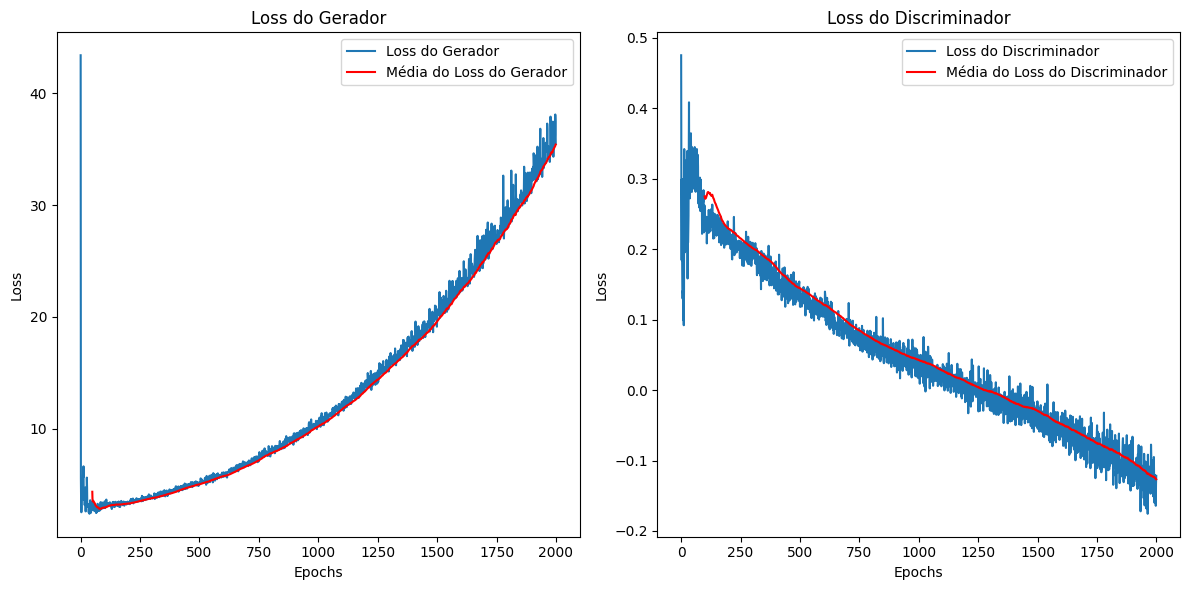

In [11]:
generator_loss = history.history['g_loss']
generator_loss_series = pd.Series(generator_loss)
generator_loss_rolling = generator_loss_series.rolling(window=50).mean()

discriminator_loss = history.history['d_loss']
discriminator_loss_series = pd.Series(discriminator_loss)
discriminator_loss_rolling = discriminator_loss_series.rolling(window=100).mean()

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(generator_loss, label='Loss do Gerador')
plt.plot(generator_loss_rolling, color='r', linestyle='-', label = 'Média do Loss do Gerador')
plt.title('Loss do Gerador')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(discriminator_loss, label='Loss do Discriminador')
plt.plot(discriminator_loss_rolling, color='r', linestyle='-', label = 'Média do Loss do Discriminador')
plt.title('Loss do Discriminador')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Menor FID:           54.108001708984375
Época da menor perda:  1758


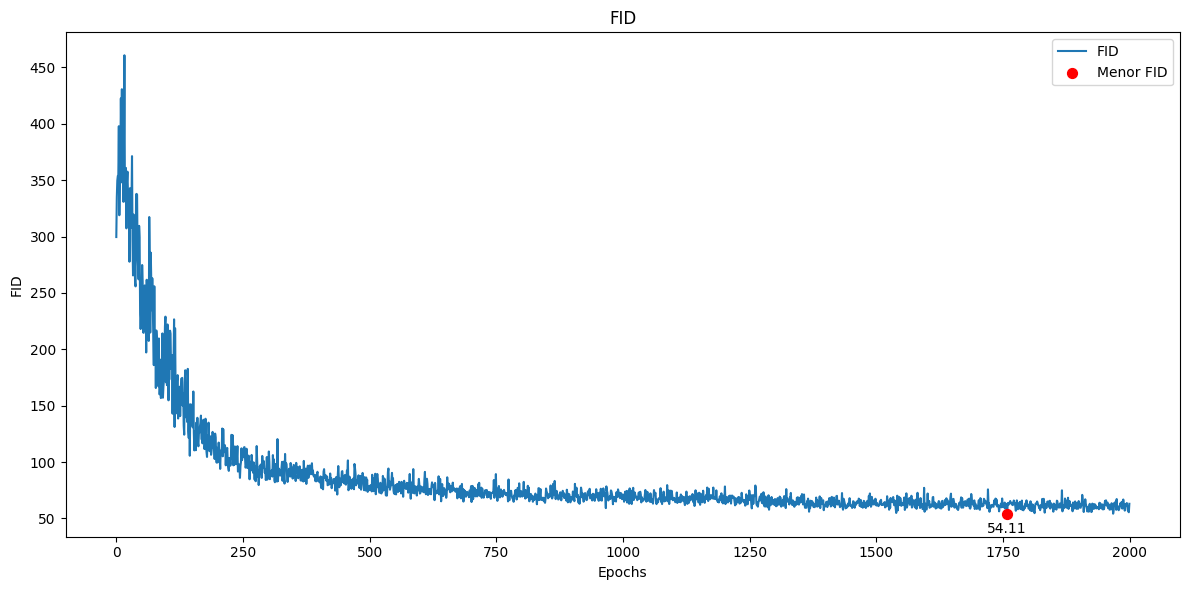

In [12]:
menor_fid = 999
for i in range(epochs):
    if save_fid[i]<menor_fid:
        menor_fid = save_fid[i]
        epoch_m = i
        
print('Menor FID:          ',menor_fid)
print('Época da menor perda: ',epoch_m)

plt.figure(figsize=(12,6))
plt.plot(save_fid, label='FID')
plt.scatter(epoch_m, menor_fid, color='r', zorder=5, label = 'Menor FID', s=50)
plt.text(epoch_m, menor_fid-20, f"{menor_fid:.2f}", ha='center', va='bottom')
plt.title('FID')
plt.xlabel('Epochs')
plt.ylabel('FID')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
generator = keras.models.load_model(best_path)
discriminator = keras.models.load_model(best_path.replace("best_dcgan_checkpoint", "best_dcgan_discriminator"))

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim, d_steps=d_steps)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [15]:
num_img = 5400
output_dir = str(fake_dir + "/" + generating_class + "/")
os.makedirs(output_dir, exist_ok=True)
filename = str(generating_class + "%d.png")
output_path = os.path.join(output_dir, filename)

latent_dim=128
seed_generator = keras.random.SeedGenerator(1337)

for i in tqdm(range(num_img),desc="Gerando imagens"):
    random_latent_vectors = keras.random.normal(
        shape=(1, latent_dim), seed=seed_generator
    )
    generated_images = gan.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    img = keras.utils.array_to_img(generated_images[0])
    img.save(output_path % (i))

Gerando imagens: 100%|██████████████████████████████████████████████████████████████| 5400/5400 [01:06<00:00, 80.62it/s]


Processando classe 'VEHICLESCARRIER': 100%|███████████████████████████████████████████| 540/540 [09:02<00:00,  1.00s/it]



Métricas para a classe 'VEHICLESCARRIER':
  SSIM (média): 0.2046
  Inception Score (Real): 1.5944
  Inception Score (Gerado): 1.5503
  FID: 45.5195


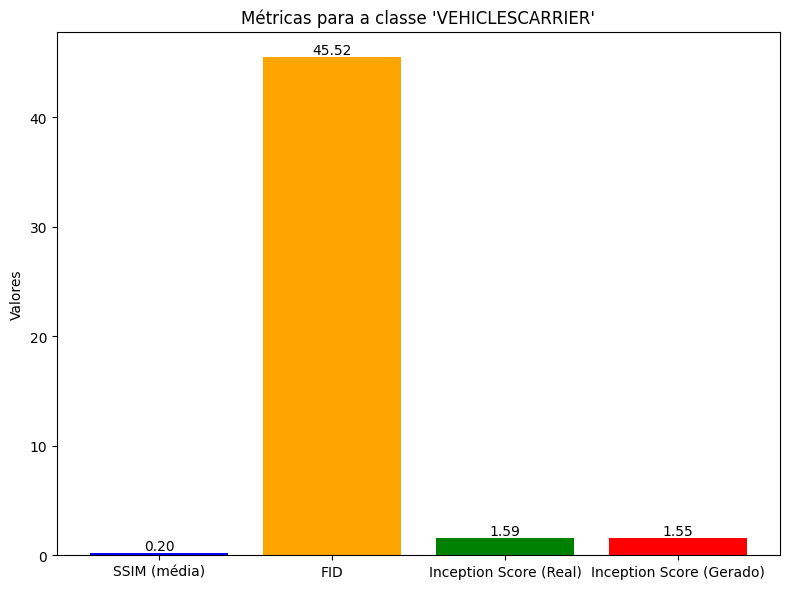

In [18]:
metrics = calculate_metrics(real_dir, fake_dir, generating_class, num_samples=num_img)
print_metrics(metrics, generating_class)
plot_metrics_for_class(metrics, generating_class)

In [15]:
# Caminhos para as imagens de entrada e saída
input_dir = str(fake_dir + '/' + generating_class)   # Substitua pelo diretório das imagens de entrada
output_dir = str(fake_dirx4 + '/' + generating_class)  # Substitua pelo diretório das imagens de saída

# Certifique-se de que o diretório de saída existe
os.makedirs(output_dir, exist_ok=True)

process_images(input_dir, output_dir)
print("Processamento concluído!")

Aumentando imagens: 100%|███████████████████████████████████████████████████████████| 5400/5400 [04:56<00:00, 18.22it/s]

Processamento concluído!


Processando classe 'VEHICLESCARRIER': 100%|███████████████████████████████████████████| 540/540 [09:10<00:00,  1.02s/it]



Métricas para a classe 'VEHICLESCARRIER':
  SSIM (média): 0.2500
  Inception Score (Real): 1.5946
  Inception Score (Gerado): 1.6938
  FID: 15.7157


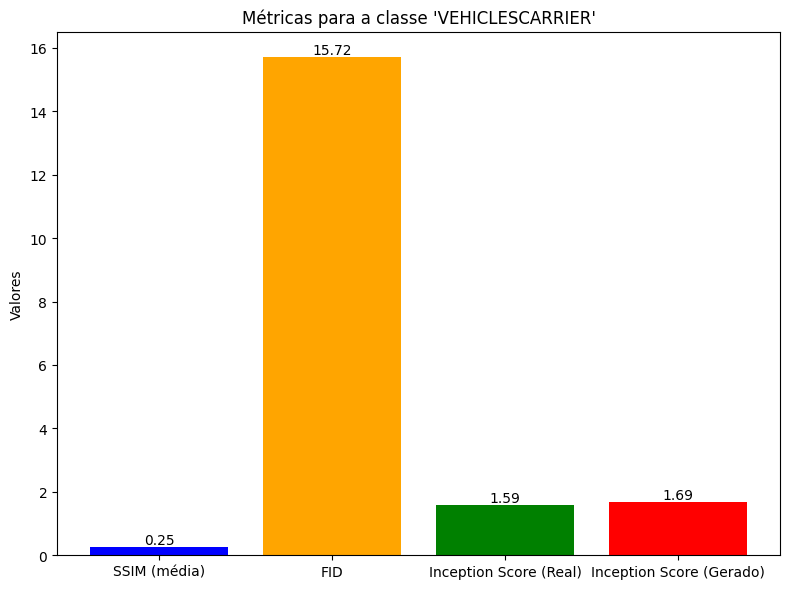

In [19]:
metrics = calculate_metrics(real_dir, fake_dirx4, generating_class, num_samples=num_img)
print_metrics(metrics, generating_class)
plot_metrics_for_class(metrics, generating_class)